In [3]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
## data loading ##

## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')
gdp_thai = pd.read_csv('data_imf/thailand_gdp_imf.csv', delimiter=';')
gdp_viet = pd.read_csv('data_imf/vietnam_gdp_imf.csv', delimiter=';')
temp = pd.read_csv('temp_cambodia.csv')
temp_average = pd.read_csv('temp_month_cambodia.csv')

data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})
gdp_thai = gdp_thai.rename(columns={'GDP (Billions of U.S. dollars)': 'gdp_thai'})
gdp_viet = gdp_viet.rename(columns={'GDP (Billions of U.S. dollars)': 'gdp_viet'})
temp = temp.rename(columns={'Annual Mean': 'temp_annual'})
temp_average = temp_average.rename(columns={'1991-2020': 'temp_average'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]
temp = temp[['year', 'temp_annual']]
temp_average = temp_average[['month', 'temp_average']]
temp_average = temp_average.dropna()
temp_average['month'] = pd.to_datetime(temp_average['month'], format= '%b').dt.month

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%d %H:%M:%S')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})

# extract DateTime components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week

# Merge data with GDP data
df = pd.merge(df, gdp_thai, on='year', how='left')
df = pd.merge(df, gdp_viet, on='year', how='left')
df = pd.merge(df, temp, on='year', how='left')

# Merge data with temperature data
df = pd.merge(df, temp_average, on='month', how='left')
df.set_index('date', inplace=True)

# add lag rainfall features
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)
df['rainfall_lag3'] = df['rainfall'].shift(3)
df['rainfall_lag1week'] = df['rainfall'].shift(7)
df['rainfall_lag2weeks'] = df['rainfall'].shift(14)
df['rainfall_lag3weeks'] = df['rainfall'].shift(21)
df['rainfall_lag4weeks'] = df['rainfall'].shift(28)
df['rainfall_lag5weeks'] = df['rainfall'].shift(35)
df['rainfall_lag10weeks'] = df['rainfall'].shift(70)
df['rainfall_week'] = df['rainfall'].rolling(window=7, min_periods=1).mean()
df['rainfall_total_week'] = df['rainfall'].rolling(window=7, min_periods=1).sum()

# drop non-needed columns
df = df.drop(columns=['day', 'day_of_week', 'day_of_year'])

# drop rows with missing values
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4325 entries, 2008-05-03 00:00:00+00:00 to 2022-11-28 00:00:00+00:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rainfall             4325 non-null   float64
 1   flowrate             4325 non-null   float64
 2   year                 4325 non-null   int64  
 3   month                4325 non-null   int64  
 4   week_of_year         4325 non-null   UInt32 
 5   gdp_thai             4325 non-null   float64
 6   gdp_viet             4325 non-null   float64
 7   temp_annual          4325 non-null   float64
 8   temp_average         4325 non-null   float64
 9   rainfall_lag1        4325 non-null   float64
 10  rainfall_lag2        4325 non-null   float64
 11  rainfall_lag3        4325 non-null   float64
 12  rainfall_lag1week    4325 non-null   float64
 13  rainfall_lag2weeks   4325 non-null   float64
 14  rainfall_lag3weeks   4325 non-null   flo

In [82]:
## Trends and Seasonality ##

# plot time series decomposition
def plot_decomposition(data, column):
    result = seasonal_decompose(data[column], model='additive')
    fig = result.plot()
    fig.set_size_inches(14, 10)
    fig.suptitle('Time Series Decomposition')
    plt.show()
    
def plot_stl_decomposition(data, column):
    stl = STL(data[column])
    result = stl.fit()
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))
    fig.suptitle('STL Decomposition')
    
    ax1.plot(result.observed)
    ax1.set_ylabel('Observed')
    
    ax2.plot(result.trend)
    ax2.set_ylabel('Trend')
    
    ax3.plot(result.seasonal)
    ax3.set_ylabel('Seasonal')
    
    ax4.plot(result.resid)
    ax4.set_ylabel('Residual')
    
    plt.show()

# plot ACF and PACF
def plot_acf_pacf(data, column, lags=52):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Autocorrelation Function (ACF)
    plot_acf(data[column].dropna(), ax=axes[0], lags=lags)
    axes[0].set_title('Autocorrelation Function')
    
    # Partial Autocorrelation Function (PACF)
    plot_pacf(data[column].dropna(), ax=axes[1], lags=lags)
    axes[1].set_title('Partial Autocorrelation Function')
    
    plt.show()

# Store trends data
def get_trends(data, columns):
    trends = data.copy()
    for column in columns:
        result = seasonal_decompose(data[column], model='additive', period=365)
        trends[f'{column}_trend'] = result.trend
        trends[f'{column}_seasonal'] = result.seasonal
    return trends

def get_STL_trends(data, columns, period):
    trends = data.copy()
    for column in columns:
        stl = STL(data[column], period=period)
        result = stl.fit()
        trends[f'{column}_trend'] = result.trend
        trends[f'{column}_seasonal'] = result.seasonal
        trends[f'{column}_residual'] = result.resid
    return trends

trends = get_trends(df, ['flowrate', 'rainfall', 'rainfall_week', 'rainfall_total_week', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_lag1week', 'rainfall_lag2weeks', 'rainfall_lag3weeks', 'rainfall_lag4weeks', 'rainfall_lag10weeks'])
trends.dropna(inplace=True)

trends_STL = get_STL_trends(df, ['flowrate', 'rainfall', 'rainfall_week', 'rainfall_total_week','rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_lag1week', 'rainfall_lag2weeks', 'rainfall_lag3weeks', 'rainfall_lag4weeks', 'rainfall_lag10weeks'], 365)
trends_STL.dropna(inplace=True)

# scale features
scaler_rain = StandardScaler()
trends[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_total_week', 'rainfall_lag1week', 'rainfall_lag2weeks', 'rainfall_lag3weeks', 'rainfall_lag4weeks', 'rainfall_lag10weeks']] = scaler_rain.fit_transform(trends[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_total_week','rainfall_lag1week', 'rainfall_lag2weeks', 'rainfall_lag3weeks', 'rainfall_lag4weeks', 'rainfall_lag10weeks']])
trends_STL[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_total_week','rainfall_lag1week', 'rainfall_lag2weeks', 'rainfall_lag3weeks', 'rainfall_lag4weeks', 'rainfall_lag10weeks']] = scaler_rain.fit_transform(trends_STL[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_total_week','rainfall_lag1week', 'rainfall_lag2weeks', 'rainfall_lag3weeks', 'rainfall_lag4weeks', 'rainfall_lag10weeks']])
scaler_flow = StandardScaler()
trends[['flowrate']] = scaler_flow.fit_transform(trends[['flowrate']])
trends_STL[['flowrate']] = scaler_flow.fit_transform(trends_STL[['flowrate']])
gdp_thai_scaler = StandardScaler()
trends[['gdp_thai']] = gdp_thai_scaler.fit_transform(trends[['gdp_thai']])
trends_STL[['gdp_thai']] = gdp_thai_scaler.fit_transform(trends_STL[['gdp_thai']])
gdp_viet_scaler = StandardScaler()
trends[['gdp_viet']] = gdp_viet_scaler.fit_transform(trends[['gdp_viet']])
trends_STL[['gdp_viet']] = gdp_viet_scaler.fit_transform(trends_STL[['gdp_viet']])
temp_scaler = StandardScaler()
trends[['temp_annual', 'temp_average']] = temp_scaler.fit_transform(trends[['temp_annual', 'temp_average']])
trends_STL[['temp_annual', 'temp_average']] = temp_scaler.fit_transform(trends_STL[['temp_annual', 'temp_average']])

scaler_flow_trend = StandardScaler()
trends[['flowrate_trend']] = scaler_flow_trend.fit_transform(trends[['flowrate_trend']])
scaler_rain_trend = StandardScaler()
trends[['rainfall_trend', 'rainfall_week_trend', 'rainfall_total_week_trend','rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag5weeks_trend', 'rainfall_lag1week_trend', 'rainfall_lag2weeks_trend', 'rainfall_lag3weeks_trend', 'rainfall_lag4weeks_trend', 'rainfall_lag10weeks_trend']] = scaler_rain_trend.fit_transform(trends[['rainfall_trend', 'rainfall_week_trend', 'rainfall_total_week_trend','rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag5weeks_trend', 'rainfall_lag1week_trend', 'rainfall_lag2weeks_trend', 'rainfall_lag3weeks_trend', 'rainfall_lag4weeks_trend', 'rainfall_lag10weeks_trend']])
scaler_flowSTL = StandardScaler()
trends_STL[['flowrate_trend']] = scaler_flowSTL.fit_transform(trends_STL[['flowrate_trend']])
scaler_rainSTL = StandardScaler()
trends_STL[['rainfall_trend', 'rainfall_week_trend', 'rainfall_total_week_trend', 'rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag5weeks_trend', 'rainfall_lag1week_trend', 'rainfall_lag2weeks_trend', 'rainfall_lag3weeks_trend', 'rainfall_lag4weeks_trend', 'rainfall_lag10weeks_trend']] = scaler_rainSTL.fit_transform(trends_STL[['rainfall_trend', 'rainfall_week_trend', 'rainfall_total_week_trend','rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag5weeks_trend', 'rainfall_lag1week_trend', 'rainfall_lag2weeks_trend', 'rainfall_lag3weeks_trend', 'rainfall_lag4weeks_trend', 'rainfall_lag10weeks_trend']])


In [83]:
## create an artificial seasonal component by extracting a portion of the seasonal flowrate and replicating it

# extract flowrate_seasonal along with week_of_year from 2014 
seasonal = trends[trends['year'] == 2014]['flowrate_seasonal'].copy()
seasonal = seasonal.reset_index(drop=True)

# Replicate seasonal component to have data for the whole dataset
replicated_seasonal = pd.concat([seasonal] * ((len(trends) // len(seasonal)) + 1), ignore_index=True)

# Trim the replicated data to match the length of the original dataset
replicated_seasonal = replicated_seasonal.iloc[:len(trends)]
trends['artificial_seasonal'] = replicated_seasonal.values

## same for STL trends

seasonal = trends_STL[trends_STL['year'] == 2014]['flowrate_seasonal'].copy()
seasonal = seasonal.reset_index(drop=True)
replicated_seasonal = pd.concat([seasonal] * ((len(trends_STL) // len(seasonal)) + 1), ignore_index=True)
replicated_seasonal = replicated_seasonal.iloc[:len(trends_STL)]
trends_STL['artificial_seasonal'] = replicated_seasonal.values


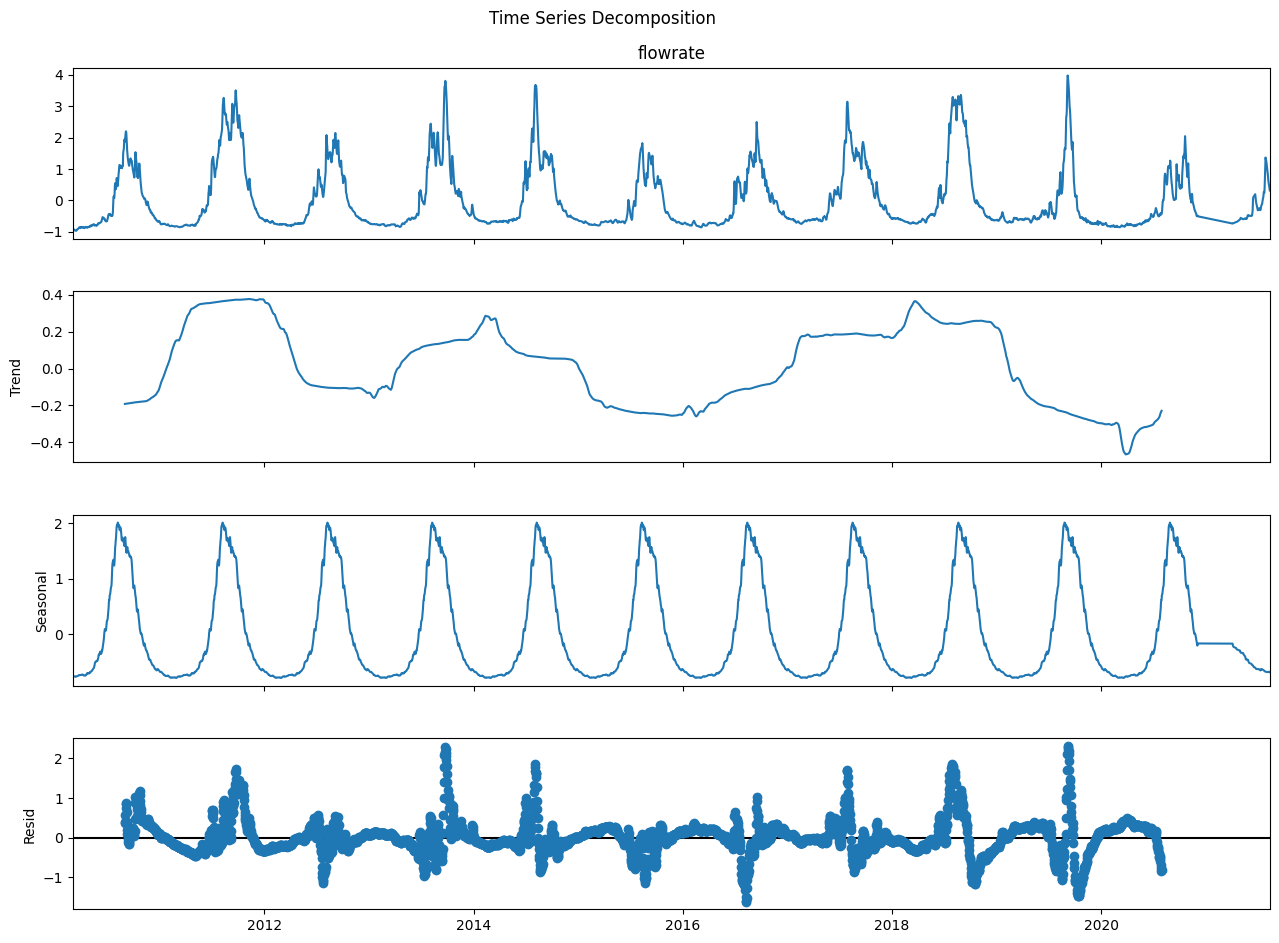

In [76]:
plot_decomposition(trends, 'flowrate')

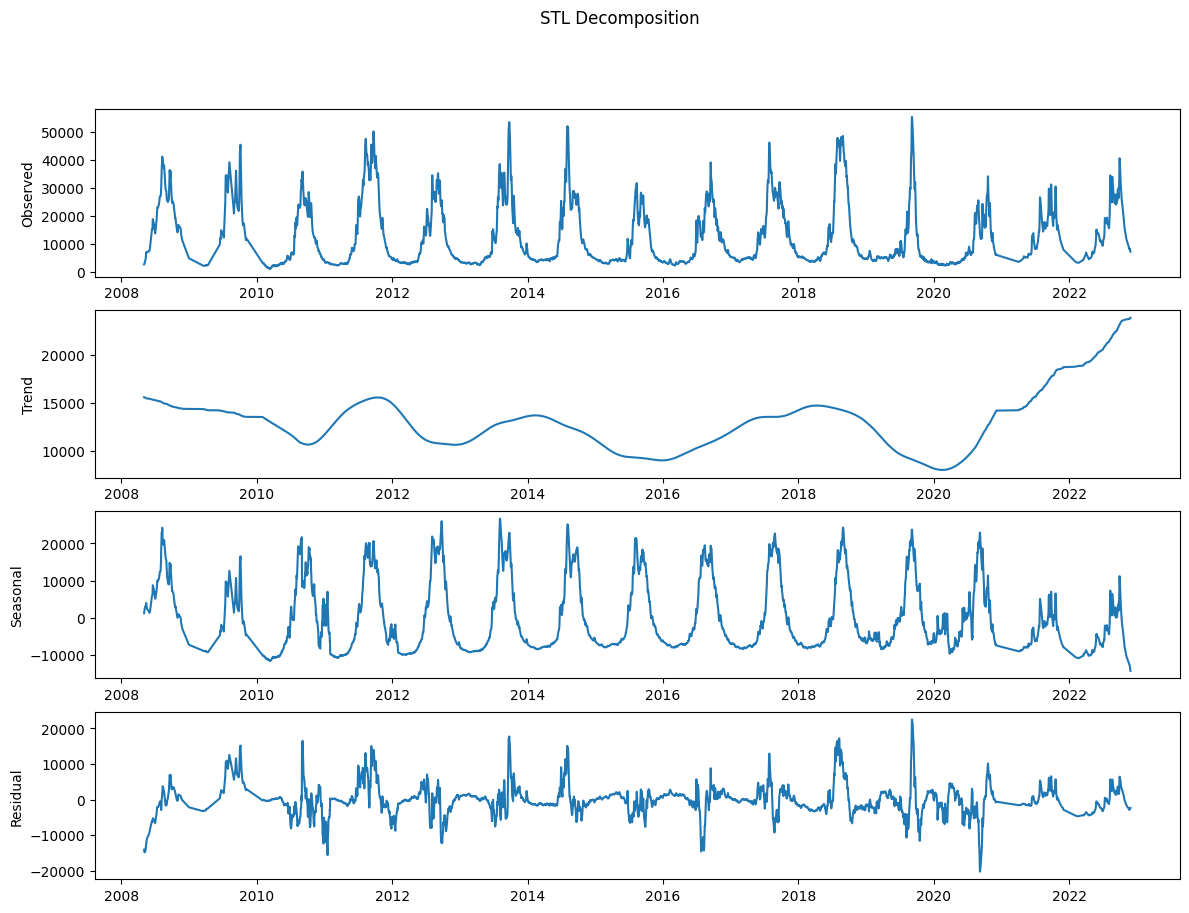

In [77]:
plot_stl_decomposition(df, 'flowrate', period=365)

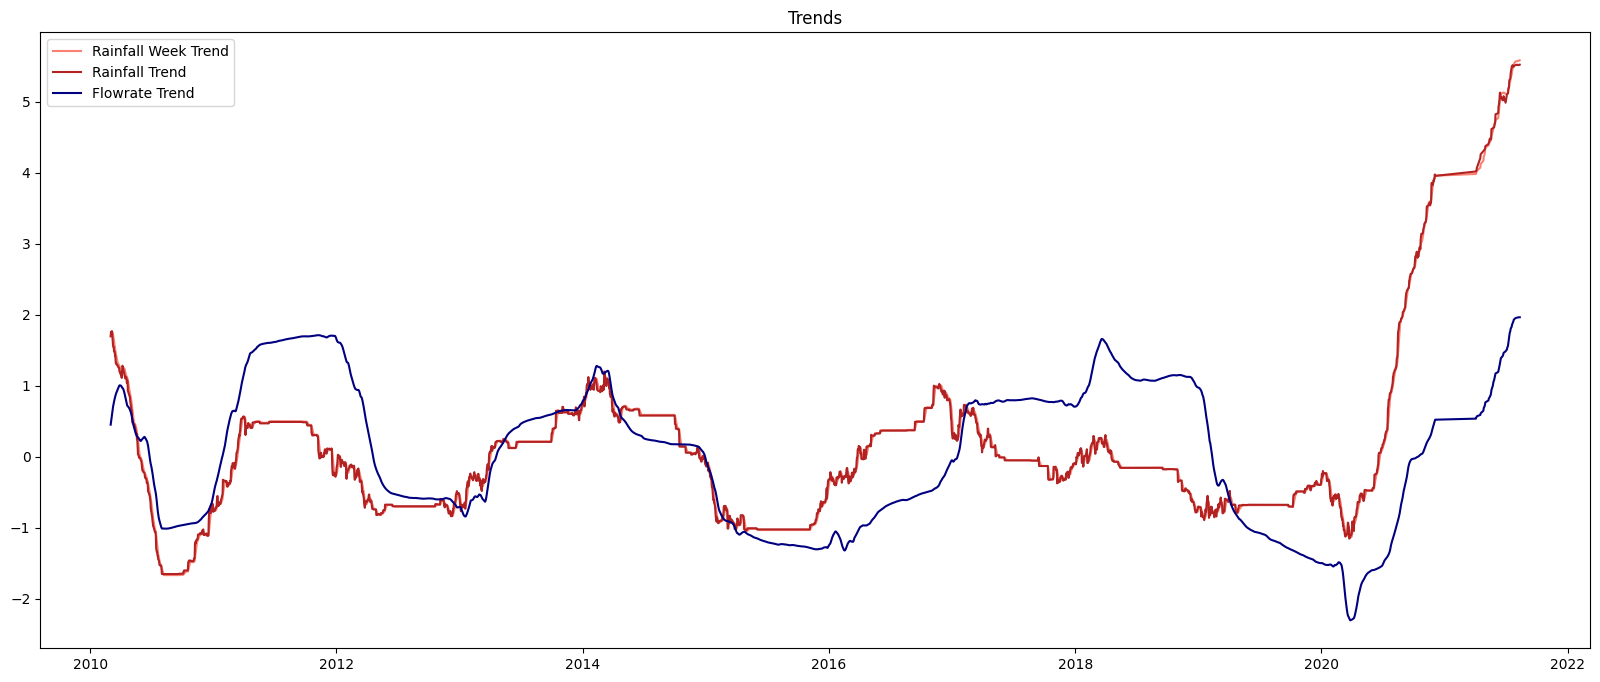

In [78]:
## plot trends ##
plt.figure(figsize=(20, 8))
plt.plot(trends['rainfall_total_week_trend'], label='Rainfall Week Trend', color='salmon')
plt.plot(trends['rainfall_trend'], label='Rainfall Trend', color='firebrick')
plt.plot(trends['flowrate_trend'], label='Flowrate Trend', color='navy')

plt.title('Trends')
plt.legend()
plt.show()

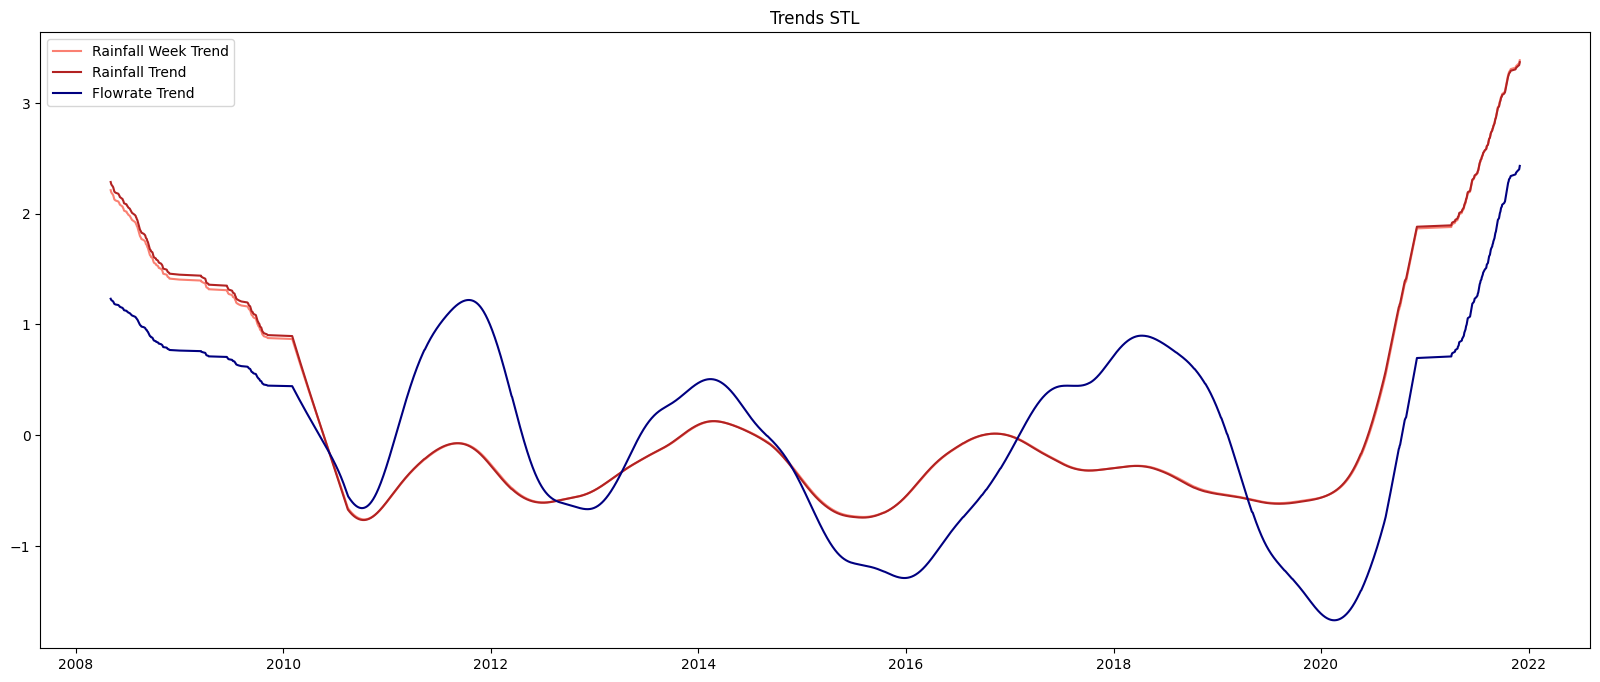

In [79]:
## plot trends STL ##
plt.figure(figsize=(20, 8))
plt.plot(trends_STL['rainfall_total_week_trend'], label='Rainfall Week Trend', color='salmon')
plt.plot(trends_STL['rainfall_trend'], label='Rainfall Trend', color='firebrick')
plt.plot(trends_STL['flowrate_trend'], label='Flowrate Trend', color='navy')

plt.title('Trends STL')
plt.legend()
plt.show()

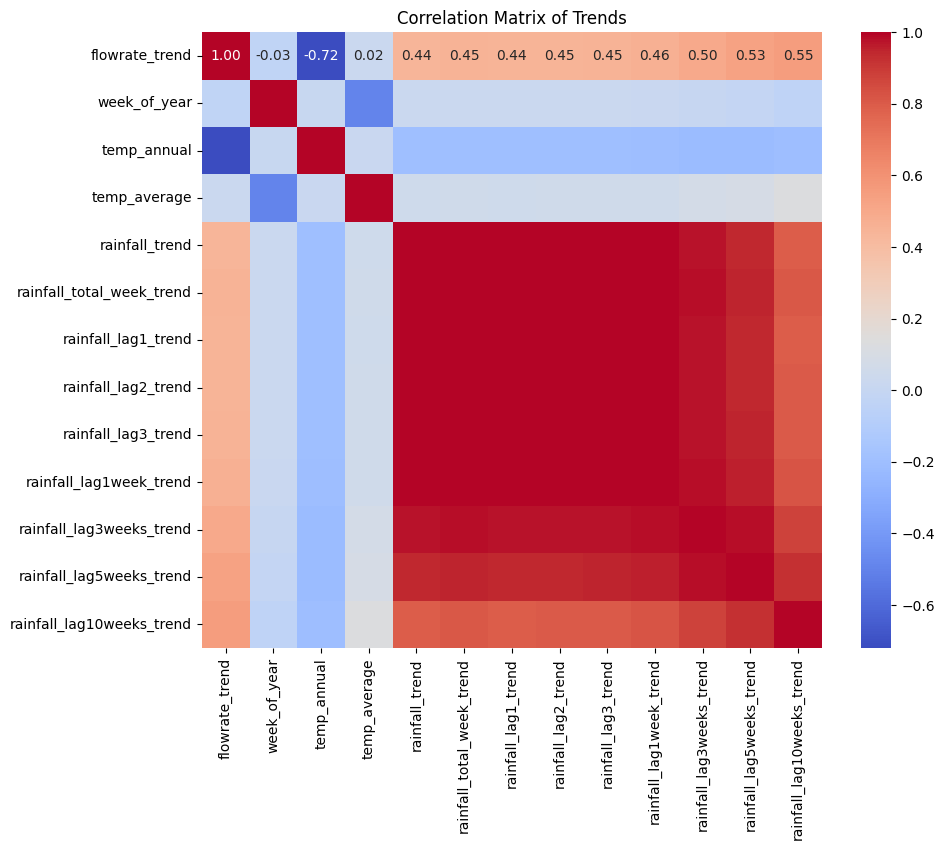

In [84]:
## Correlation Analysis ##
correlation = trends[['flowrate_trend', 'week_of_year', 'temp_annual', 'temp_average', 'rainfall_trend', 'rainfall_total_week_trend', 'rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag1week_trend', 'rainfall_lag3weeks_trend', 'rainfall_lag5weeks_trend',  'rainfall_lag10weeks_trend']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Trends')
plt.show()

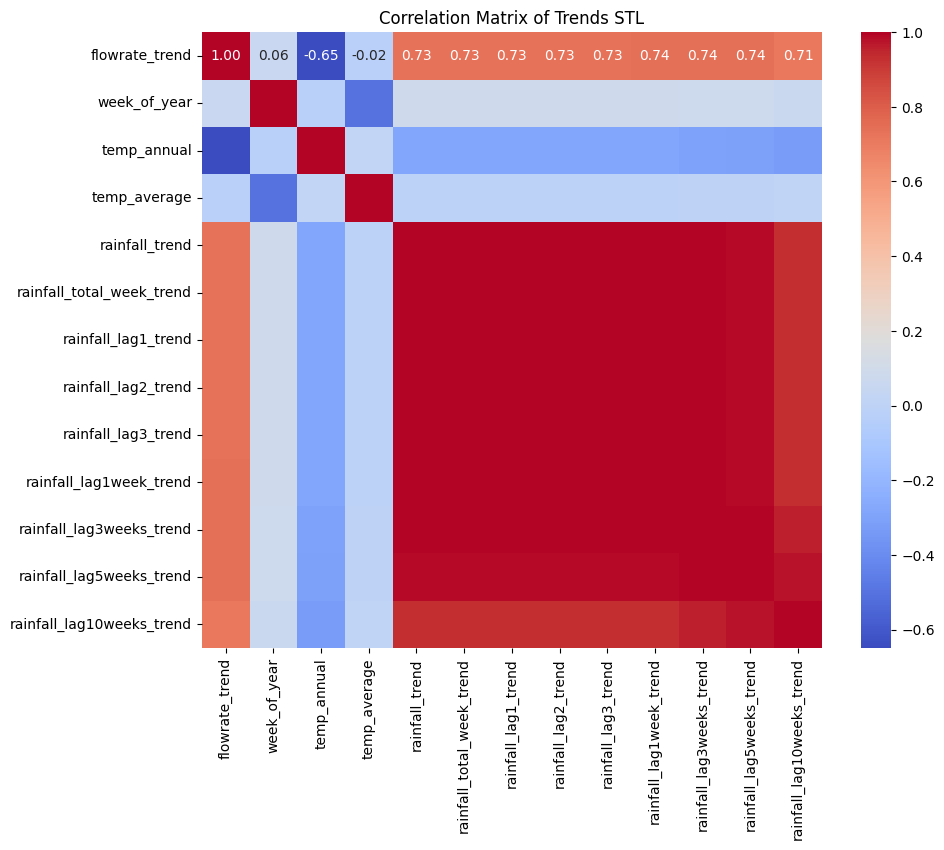

In [85]:
## Correlation Analysis STL ##
plt.figure(figsize=(10, 8))
correlation_STL = trends_STL[['flowrate_trend', 'week_of_year','temp_annual','temp_average', 'rainfall_trend', 'rainfall_total_week_trend', 'rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag1week_trend', 'rainfall_lag3weeks_trend', 'rainfall_lag5weeks_trend', 'rainfall_lag10weeks_trend']].corr()
sns.heatmap(correlation_STL, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Trends STL')
plt.show()

Mean Squared Error: 0.25938253765216246
R^2 Score: 0.7461865277502793


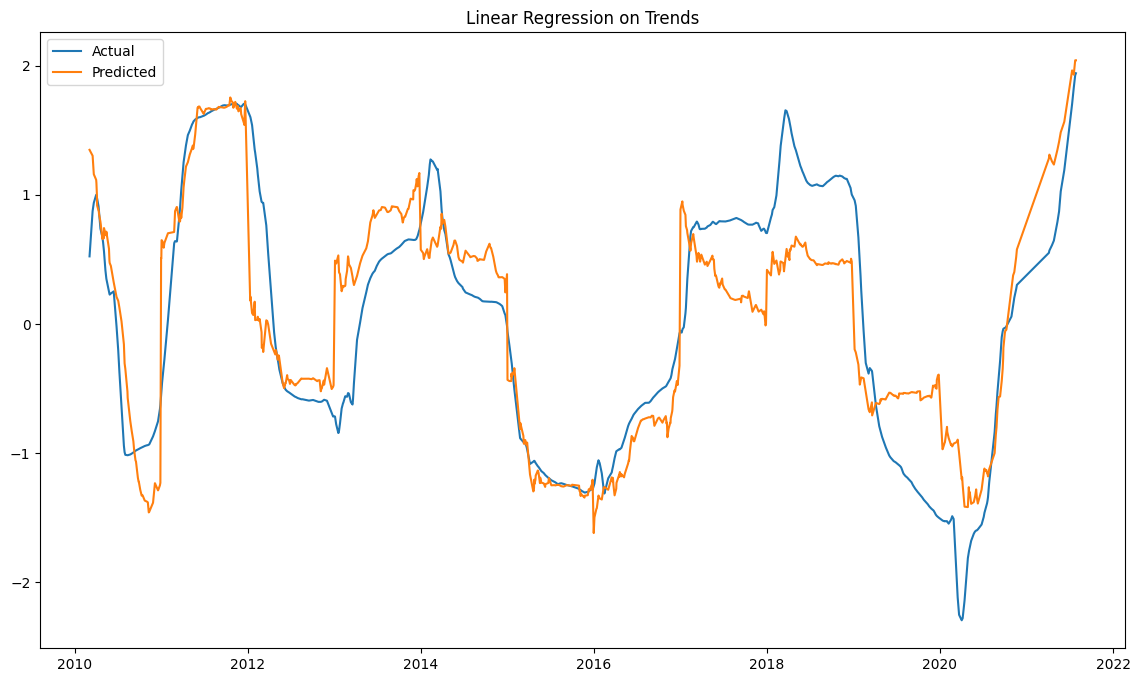

In [59]:
## Linear Regression on trends ##
X = trends[['rainfall_trend', 'week_of_year','temp_annual', 'temp_average','rainfall_total_week_trend', 'rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag1week_trend', 'rainfall_lag2weeks_trend', 'rainfall_lag3weeks_trend','rainfall_lag4weeks_trend', 'rainfall_lag5weeks_trend', 'rainfall_lag10weeks_trend', 'gdp_thai', 'gdp_viet']]
y = trends['flowrate_trend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

X_STL = trends_STL[['rainfall_trend', 'week_of_year','temp_annual', 'temp_average','rainfall_total_week_trend', 'rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag1week_trend', 'rainfall_lag2weeks_trend', 'rainfall_lag3weeks_trend','rainfall_lag4weeks_trend', 'rainfall_lag5weeks_trend', 'rainfall_lag10weeks_trend', 'gdp_thai', 'gdp_viet']]
y_STL = trends_STL['flowrate_trend']
X_train_STL, X_test_STL, y_train_STL, y_test_STL = train_test_split(X_STL, y_STL, test_size=0.2, shuffle=True)
X_train_STL = X_train_STL.sort_index()
y_train_STL = y_train_STL.sort_index()
X_test_STL = X_test_STL.sort_index()
y_test_STL = y_test_STL.sort_index()

def linear_regression(X_train, y_train, X_test, y_test, plot=False):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    
    if plot:
        # plot predictions
        plt.figure(figsize=(14, 8))
        plt.plot(y_test.index, y_test, label='Actual')
        plt.plot(y_test.index, y_pred, label='Predicted')
        plt.title('Linear Regression on Trends')
        plt.legend()
        plt.show()
    
    return y_pred, mse, r2
    
_, mse, r2 = linear_regression(X_train, y_train, X_test, y_test, plot=True)

Mean Squared Error: 0.09651996552666112
R^2 Score: 0.9007566620591998


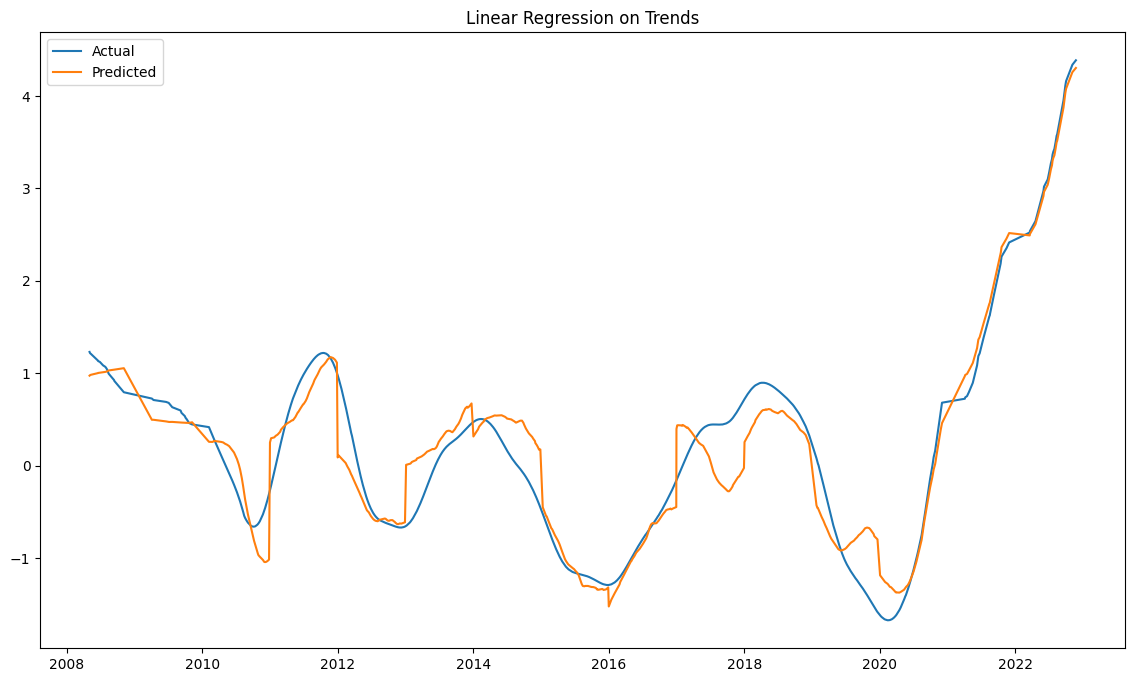

In [60]:
_, mse_STL, r2_STL = linear_regression(X_train_STL, y_train_STL, X_test_STL, y_test_STL, plot=True)

Mean Squared Error: 0.06054137572188486
R^2 Score: 0.9407584761648335


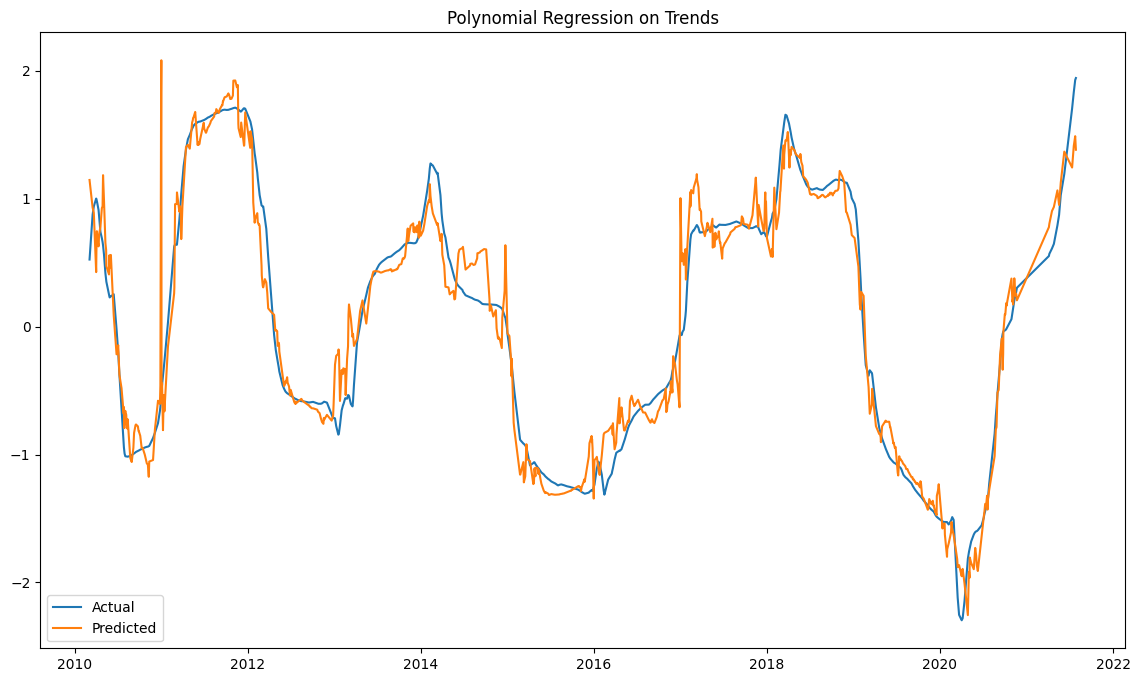

In [61]:
## polynomial regression on trends ##
def polynomial_regression(X_train, X_test, y_train, y_test, plot=False):
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)
    y_pred_poly = model_poly.predict(X_test_poly)

    # evaluate model
    mse_poly = mean_squared_error(y_test, y_pred_poly)
    r2_poly = r2_score(y_test, y_pred_poly)
    print(f'Mean Squared Error: {mse_poly}')
    print(f'R^2 Score: {r2_poly}')
    
    if plot:
        # plot predictions
        plt.figure(figsize=(14, 8))
        plt.plot(y_test.index, y_test, label='Actual')
        plt.plot(y_test.index, y_pred_poly, label='Predicted')
        plt.title('Polynomial Regression on Trends')
        plt.legend()
        plt.show()
    
    return y_pred_poly, mse_poly, r2_poly

_, mse_poly, r2_poly = polynomial_regression(X_train, X_test, y_train, y_test, plot=True)

Mean Squared Error: 0.000850231981601662
R^2 Score: 0.9991257781805272


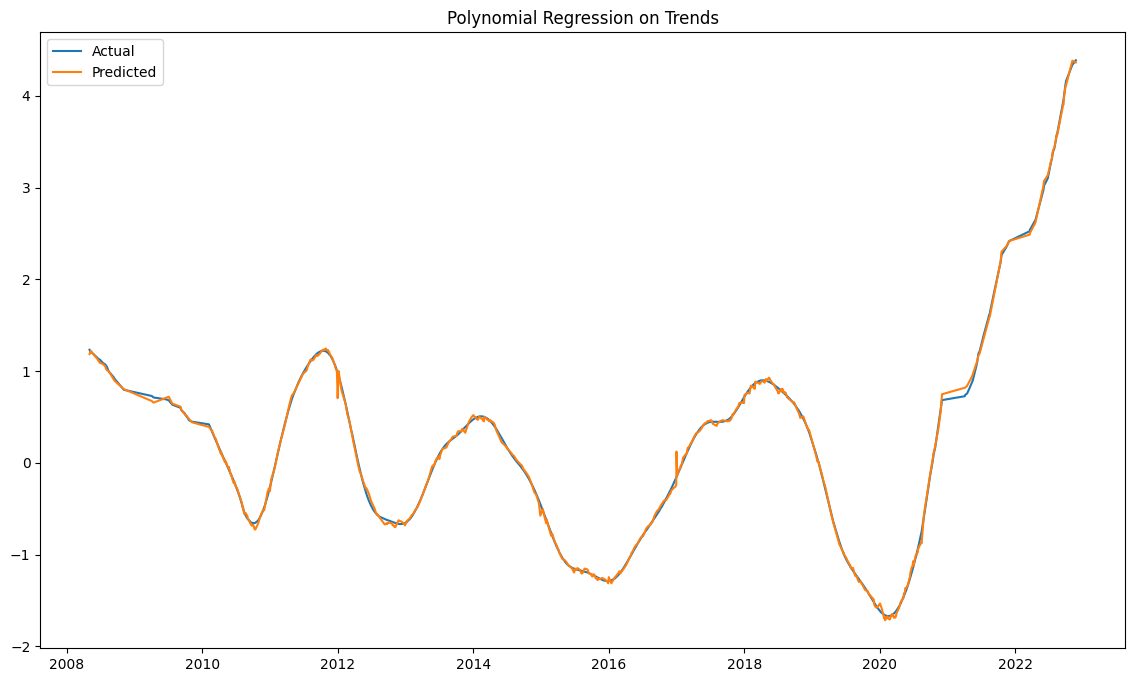

In [62]:
_, mse_poly_STL, r2_poly_STL = polynomial_regression(X_train_STL, X_test_STL, y_train_STL, y_test_STL, plot=True)

In [63]:
## store results ##
results = pd.DataFrame(columns=['Trend Linear Reg Model', 'Mean Squared Error', 'R-squared'])
results.loc[0] = ['Trend Linear Regression', mse, r2]
results.loc[1] = ['Trend Polynomial Regression', mse_poly, r2_poly]
results.loc[2] = ['Trend Linear Regression STL', mse_STL, r2_STL]
results.loc[3] = ['Trend Polynomial Regression STL', mse_poly_STL, r2_poly_STL]
results.sort_values(by='Mean Squared Error', ascending=True, inplace=True)
results

,Trend Linear Reg Model,Mean Squared Error,R-squared
3,Trend Polynomial Regression STL,0.000850,0.999126
1,Trend Polynomial Regression,0.060541,0.940758
2,Trend Linear Regression STL,0.096520,0.900757
0,Trend Linear Regression,0.259383,0.746187


In [64]:
## recompose data with trend prediction ##
def recompose_data(data, model, column, plot=False):
    X = data[['rainfall_trend', 'rainfall_week_trend', 'rainfall_total_week_trend','rainfall_lag1_trend', 'rainfall_lag2_trend', 'rainfall_lag3_trend', 'rainfall_lag1week_trend', 'rainfall_lag2weeks_trend', 'rainfall_lag3weeks_trend','rainfall_lag4weeks_trend', 'rainfall_lag5weeks_trend', 'rainfall_lag10weeks_trend', 'gdp_thai', 'gdp_viet']]
    y = data[f'{column}_trend']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    X_train = X_train.sort_index()
    y_train = y_train.sort_index()
    X_test = X_test.sort_index()
    y_test = y_test.sort_index()
    
    if model == 'linear':
        y_pred, _, _ = linear_regression(X_train, y_train, X_test, y_test, plot)
    elif model == 'polynomial':
        y_pred, _, _ = polynomial_regression(X_train, X_test, y_train, y_test, plot)
    else:
        return 'unrecognized model'

    y_pred = scaler_flow_trend.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    recomposed = y_pred + data['artificial_seasonal'][data.index.isin(y_test.index)]
    
    actual = scaler_flow.inverse_transform(data['flowrate'].values.reshape(-1, 1))
    real = scaler_flow.transform(actual[data.index.isin(recomposed.index)])
    pred = scaler_flow.transform(recomposed.values.reshape(-1, 1))
    mse = mean_squared_error(real, pred)
    
    return recomposed, mse

recomposed, mse_recomposed = recompose_data(trends, 'linear', 'flowrate')
recomposed_poly, mse_recomposed_poly = recompose_data(trends, 'polynomial', 'flowrate')
recomposed_STL, mse_recomposed_STL = recompose_data(trends_STL, 'linear', 'flowrate')
recomposed_poly_STL, mse_recomposed_poly_STL = recompose_data(trends_STL, 'polynomial', 'flowrate')

Mean Squared Error: 0.4401764074664908
R^2 Score: 0.5422168758869734
Mean Squared Error: 0.1708417487173999
R^2 Score: 0.822324713160058
Mean Squared Error: 0.16523707554391584
R^2 Score: 0.8546234453381172
Mean Squared Error: 0.0021272698051675006
R^2 Score: 0.9981284154655151


c:\Users\lelia\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\lelia\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\lelia\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\lelia\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\lelia\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\lelia\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid f

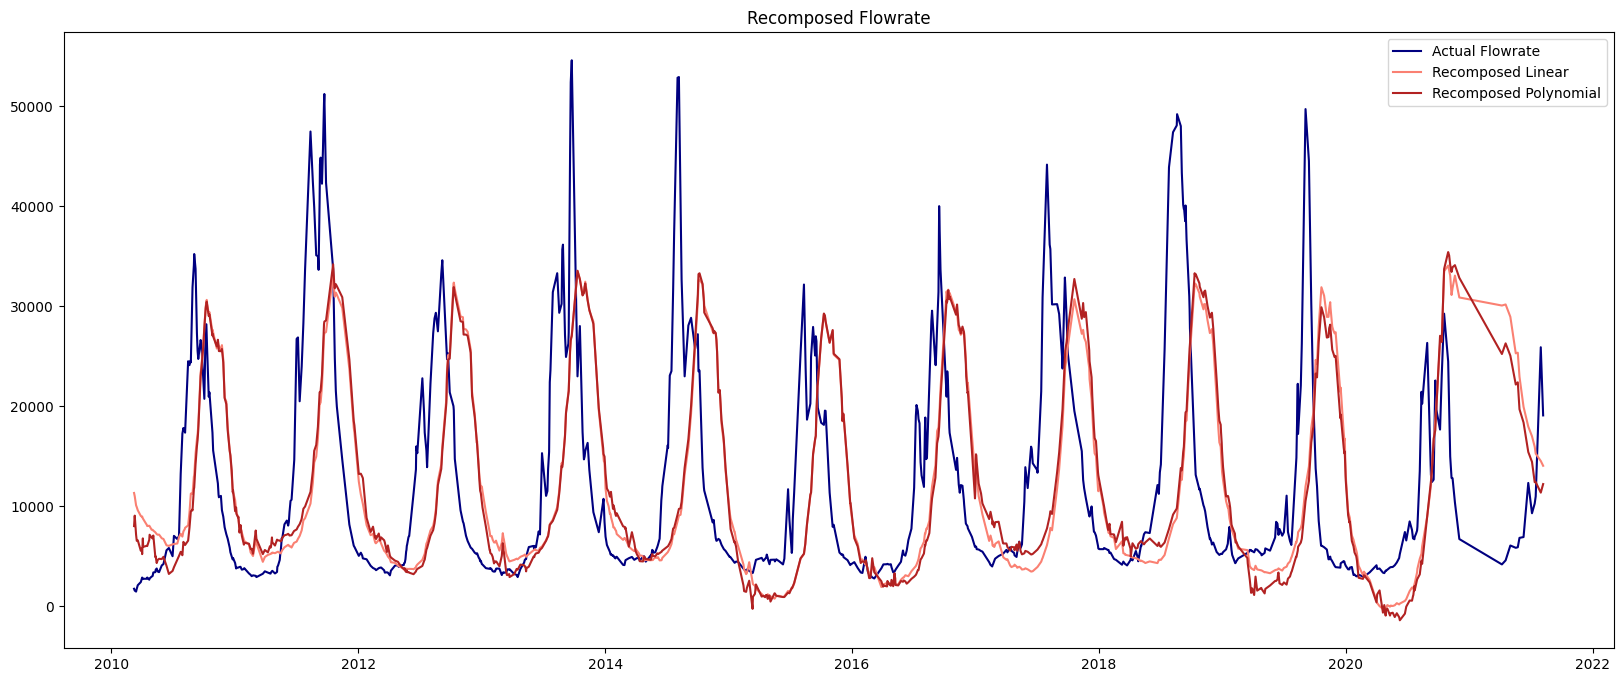

In [66]:
## plot recomposed data ##
plt.figure(figsize=(20, 8))
actual = scaler_flow.inverse_transform(trends['flowrate'].values.reshape(-1, 1))
plt.plot(recomposed.index, actual[trends.index.isin(recomposed.index)], label='Actual Flowrate', color='navy')
plt.plot(recomposed.index,recomposed, label='Recomposed Linear', color='salmon')
plt.plot(recomposed.index,recomposed_poly, label='Recomposed Polynomial', color='firebrick')
plt.title('Recomposed Flowrate')
plt.legend()
plt.show()

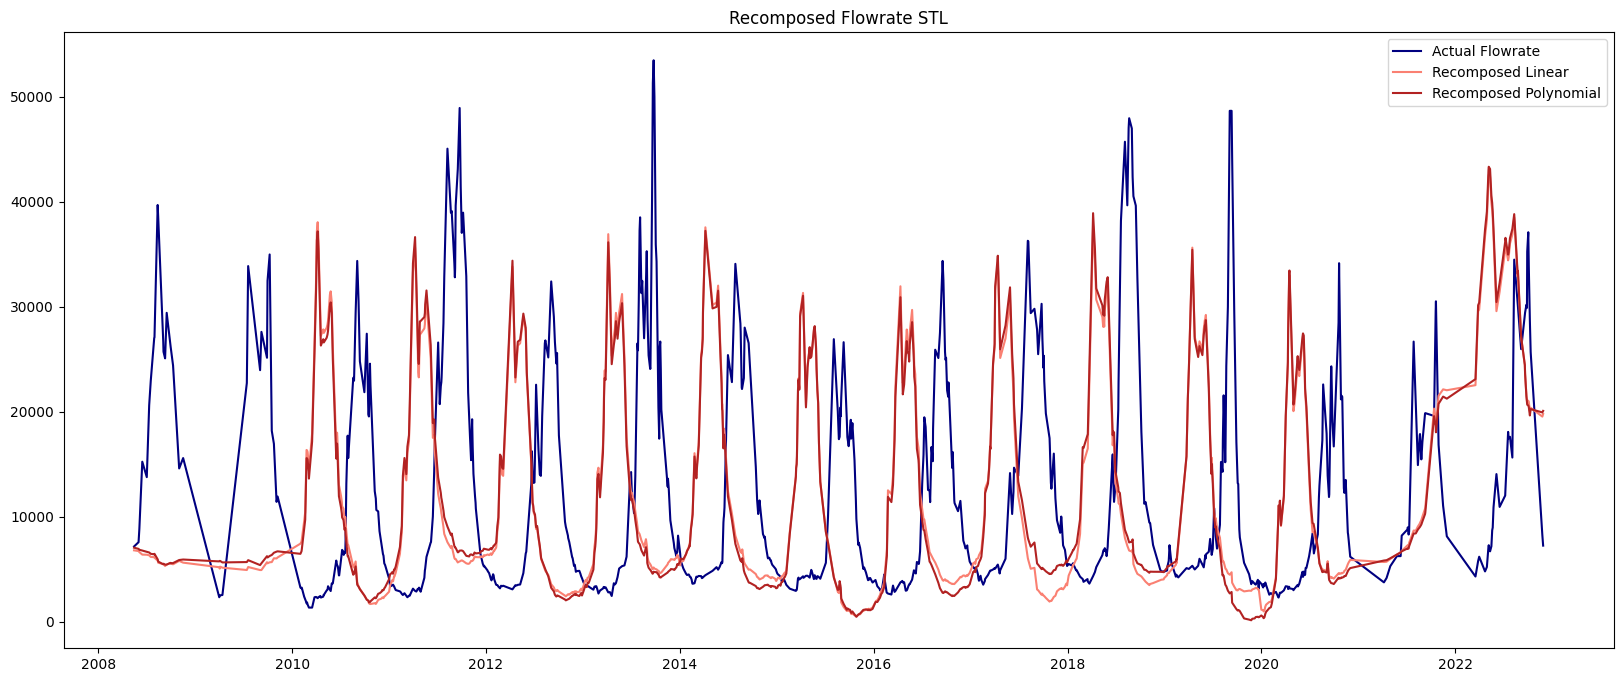

In [51]:
plt.figure(figsize=(20, 8))
actual_STL = scaler_flow.inverse_transform(trends_STL['flowrate'].values.reshape(-1, 1))
plt.plot(recomposed_STL.index, actual_STL[trends_STL.index.isin(recomposed_STL.index)], label='Actual Flowrate', color='navy')
plt.plot(recomposed_STL.index,recomposed_STL, label='Recomposed Linear', color='salmon')
plt.plot(recomposed_STL.index,recomposed_poly_STL, label='Recomposed Polynomial', color='firebrick')
plt.title('Recomposed Flowrate STL')
plt.legend()
plt.show()


In [52]:
## store recomposed results ##
results_recomposed = pd.DataFrame(columns=['Model', 'Mean Squared Error'])
results_recomposed.loc[0] = ['Linear Regression', mse_recomposed]
results_recomposed.loc[1] = ['Polynomial Regression', mse_recomposed_poly]
results_recomposed.loc[2] = ['Linear Regression STL', mse_recomposed_STL]
results_recomposed.loc[3] = ['Polynomial Regression STL', mse_recomposed_poly_STL]
results_recomposed.sort_values(by='Mean Squared Error', ascending=True, inplace=True)
results_recomposed

,Model,Mean Squared Error
1,Polynomial Regression,1.115423
0,Linear Regression,1.127218
3,Polynomial Regression STL,2.251247
2,Linear Regression STL,2.252347
